# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Importación de Librerías

In [180]:
import pandas as pd
import glob
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
########CUIDADO###########
metricas = pd.DataFrame()
np.random.seed(0)

# Preparación de los Datos

In [181]:
filenames = glob.glob('datos\precios\*.xlsx')
filenamesx = glob.glob('datos\precios\*.xls')
filenames = filenames + filenamesx

data = pd.DataFrame()
ano=1995
for f in filenames:
    if ano<2000:
        aux = pd.read_excel(f,header=3)
    
    elif ano==2000 or ano==2005 or ano>=2010 :
        aux = pd.read_excel(f,header=2)
        aux = aux.drop(['Version'],axis=1)
        
    else:
        aux = pd.read_excel(f,header=2)
        
    ano+=1  
    data = data.append(aux,sort=False)
    #data = pd.concat([data,aux])
del ano, aux, f, filenames, filenamesx
data = data.dropna(subset=['Fecha'])
data = data[data.columns[:-2]] 
data = data.fillna(0)
data['promedio'] = data.mean(axis=1)
data = data.reset_index(drop=True)
data = data[['Fecha','promedio']]
data['Fecha'] = data['Fecha'].astype('datetime64[D]')
data['anho'] = data['Fecha'].dt.strftime('%Y')
data['anho'] = data['anho'].astype('int')
data['mes'] = data['Fecha'].dt.strftime('%m')
data['mes'] = data['mes'].astype('int')
data['dia'] = data['Fecha'].dt.strftime('%d')
data['dia'] = data['dia'].astype('int')

data.head(5)

,Fecha,promedio,anho,mes,dia
0,1995-07-20,1.350708,1995,7,20
1,1995-07-21,4.924333,1995,7,21
2,1995-07-22,1.269500,1995,7,22
3,1995-07-23,0.953083,1995,7,23
4,1995-07-24,4.305917,1995,7,24


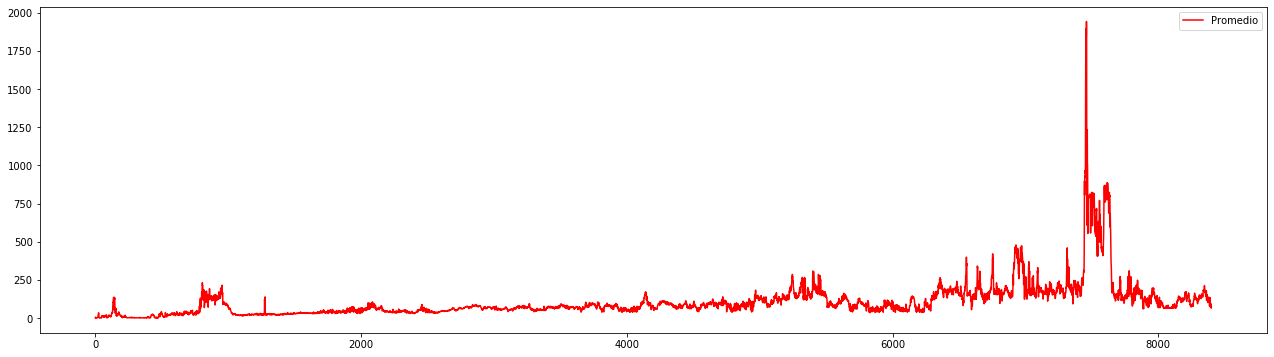

In [175]:
plt.figure(figsize=(22,6))
plt.plot(data['promedio'].values, color='red',label = 'Promedio');
plt.legend()

# Índice IPC

Debido al cambio del valor de una moneda con el tiempo debemos buscar una manera de normalizar los precios, para esto usaremos el archivo en la página del Banco de la Republica(https://www.banrep.gov.co/es/estadisticas/indice-precios-consumidor-ipc), para multiplicar los promedios por un indice IPC base 

In [182]:
ipc = pd.read_excel('datos/1.2.5.IPC_Serie_variaciones.xlsx',header =12)
ipc = ipc.iloc[:-6] 
ipc = ipc.iloc[:,0:2] 
ipc.columns = ['Corte', 'indice']
ipc.head(10)

,Corte,indice
0,202002,104.94
1,202001,104.24
2,201912,103.80
3,201911,103.54
4,201910,103.43
5,201909,103.26
6,201908,103.03
7,201907,102.94
8,201906,102.71
9,201905,102.44


In [183]:
ipc['Corte'] = ipc['Corte'].astype(str)
ipc['Corte'] = ipc['Corte'].apply(lambda x: x[:4] + '-' + x[4:])
ipc['Corte'] = pd.to_datetime(ipc['Corte']).dt.to_period('M')
data['Corte'] = pd.to_datetime(data['Fecha']).dt.to_period('M')
ipc.head(10)                                

,Corte,indice
0,2020-02,104.94
1,2020-01,104.24
2,2019-12,103.80
3,2019-11,103.54
4,2019-10,103.43
5,2019-09,103.26
6,2019-08,103.03
7,2019-07,102.94
8,2019-06,102.71
9,2019-05,102.44


In [184]:
indiceBase = ipc.tail(1).iloc[0,1]
#indiceBase = ipc['indice']
indiceBase

0.03

In [185]:
data = pd.merge(data, ipc[["Corte", "indice"]], on="Corte", how="left")
data['promedioIPC'] =  data['promedio'] * indiceBase / data['indice']
data.head(5)

,Fecha,promedio,anho,mes,dia,Corte,indice,promedioIPC
0,1995-07-20,1.350708,1995,7,20,1995-07,20.93,0.001936
1,1995-07-21,4.924333,1995,7,21,1995-07,20.93,0.007058
2,1995-07-22,1.269500,1995,7,22,1995-07,20.93,0.001820
3,1995-07-23,0.953083,1995,7,23,1995-07,20.93,0.001366
4,1995-07-24,4.305917,1995,7,24,1995-07,20.93,0.006172


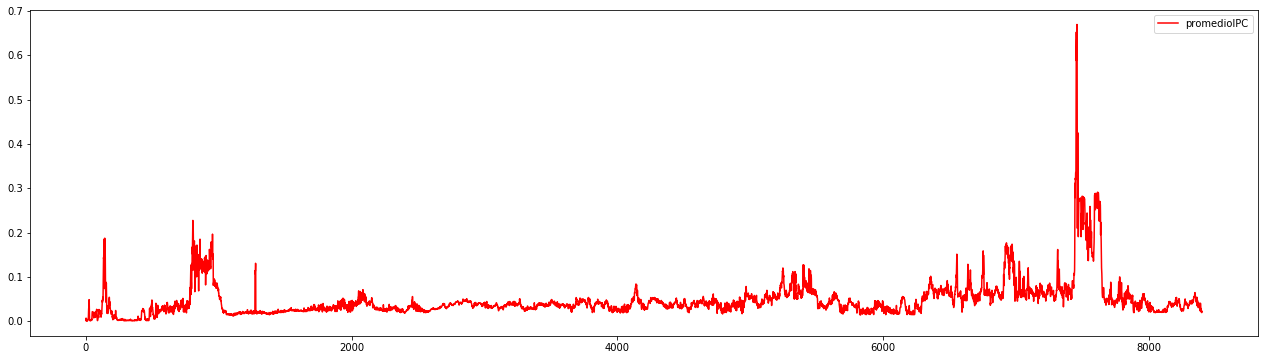

In [186]:
plt.figure(figsize=(22,6))
plt.plot(data['promedioIPC'].values, color='red', label = 'promedioIPC');
plt.legend()

# Aplicación de Transformación y Normalización

Se prueba aplicar una transformación a los datos, para ver si el comportamiento de los datos mejora, se probó con las siguientes transformaciones:
+ Raíz cuadrada
+ Raíz cúbica
+ Logaritmo natural

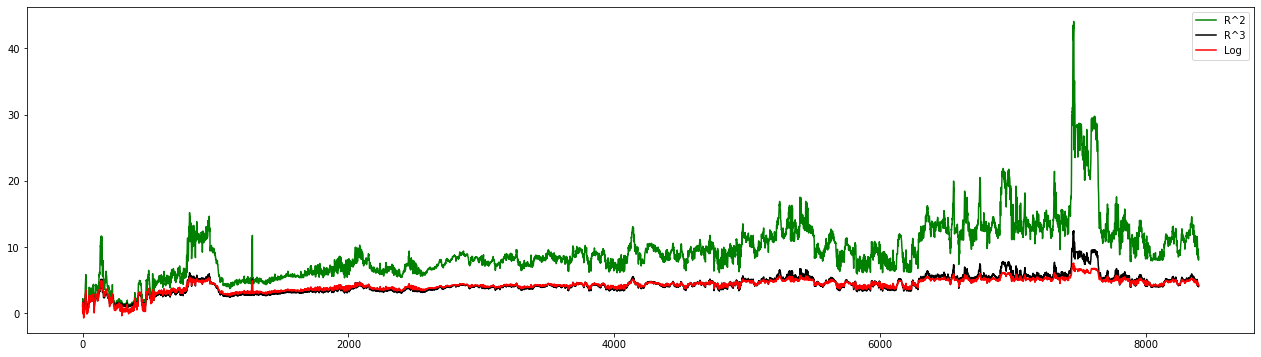

In [10]:
dataTrans = data['promedio'].copy()
dataR2 = np.sqrt(dataTrans)
dataR3 = np.power(dataTrans,(1/3))
dataLog = np.log(dataTrans)

plt.figure(figsize=(22,6))
plt.plot(dataR2, color='green',label='R^2')
plt.plot(dataR3, color='black',label='R^3')
plt.plot(dataLog, color='red',label='Log')
plt.legend()
plt.show()

Analizando las transformaciones apicadas, se decide tomar la transformación con la raíz cúbica, ya que no nos genera una
posible perdida de datos al generar valores en cero como lo es el caso de la Logaritmo natural. 

A continuación, se aplica una normalización con la herramienta MinMaxScaler de la librería sklearn

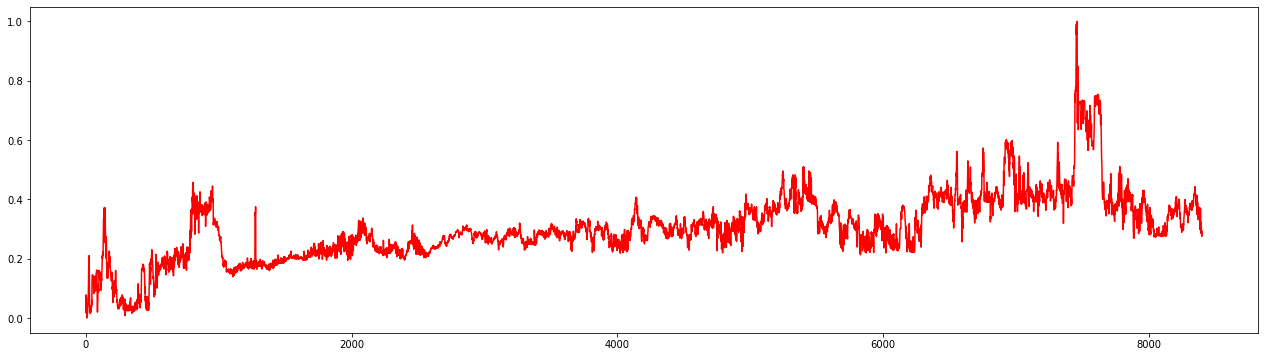

In [11]:
normalizador = MinMaxScaler().fit(np.array(dataR3).reshape(-1,1))
R3 = normalizador.transform(np.array(dataR3).reshape(-1,1))
plt.figure(figsize=(22,6))
plt.plot(R3, color = 'red')

# Implementación del Modelo

Se decide usar el modelo que propone el profesor en la materia de Redes Neuronales, se puede consultar más a fondo la explicación del modelo en el link : https://jdvelasq.github.io/courses/notebooks/sklearn/adaline/1-01-adaline-teoria.html

In [12]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

# Elección de parámetros

Para ajustar los parámetros se decició iterar sobre un dominio ya definido y se guardaron los resultados de predicción y testeo, además se guardaron las métricas mse y mae para cada modelo

In [18]:
d = list(R3.reshape(1,-1)[0])

In [45]:
metricas = pd.DataFrame()
metricas

""


In [46]:
L = 8

for lRate in (0.001,0.005,0.01,0.05,0.1):
    for epochs in (1,10,100):        
        

        ##
        ## Forma la matriz X
        ##
        X = []
        for t in range(L, len(d)):
            X.append(d[t-L:t].copy())
            model = Adaline(
            learning_rate=lRate,  # tasa de aprendizaje
            max_epochs=epochs,        # número máximo de iteraciones sobre el set de datos
            shuffle=False,       # mezcla patrones para aprendizaje online
            random_state=123,   #corrida reproducible
            warm_start=False)    #inicia con pesos aleatorios
            
        errors2, forecasts = model.fit(X,d[L:])


    
        #forecasts = normalizador.inverse_transform(np.array(dataR3).reshape(-1,1))    
    
        lonTest = 7
        test = d[len(d)-lonTest:len(d)]
        predict = forecasts[len(forecasts) - lonTest:len(forecasts)]

        
        
        mse = mean_squared_error(test, predict)
        mae = mean_absolute_error(test, predict)
        metricas = metricas.append({'learningrate': lRate, 'maxepochs': epochs, 'mse': mse, 'mae': mae, 'predict' : predict, 'test' : test}, ignore_index = True)
        
        

In [48]:
metricas

,learningrate,mae,maxepochs,mse,predict,test
0,0.001,0.098534,1.0,0.009979,"[[0.3661836572020212], [0.40316661066405896], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
1,0.001,0.027896,10.0,0.001034,"[[0.29758991426021125], [0.2980491401023847], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
2,0.001,0.022808,100.0,0.000793,"[[0.3133062474690361], [0.2986116187534412], [...","[0.28580166799481854, 0.3221729409331285, 0.28..."
3,0.005,0.090964,1.0,0.008741,"[[0.3940874770437639], [0.445447984539984], [0...","[0.28580166799481854, 0.3221729409331285, 0.28..."
4,0.005,0.033219,10.0,0.001189,"[[0.33489554911536606], [0.2762404402071219], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
5,0.005,0.018372,100.0,0.000486,"[[0.31364774748711866], [0.3100330907699105], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
6,0.010,0.057609,1.0,0.003538,"[[0.3676597514093727], [0.37861136947240426], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
7,0.010,0.027239,10.0,0.001204,"[[0.2982519484975097], [0.24656841082529662], ...","[0.28580166799481854, 0.3221729409331285, 0.28..."
8,0.010,0.019071,100.0,0.000508,"[[0.32270321183488876], [0.30300749870327254],...","[0.28580166799481854, 0.3221729409331285, 0.28..."
9,0.050,0.042860,1.0,0.003048,"[[0.4105867431842014], [0.3695630102970579], [...","[0.28580166799481854, 0.3221729409331285, 0.28..."


In [89]:
metricas['error_total'] = metricas['mae'] + metricas['mse']

print(metricas.mse.min())
print(metricas.mae.min())

0.00048555810242452267
0.018070718889245045


# Elección del Modelo

Se toma el modelo con el menor error total y se le hace un tratamiento a la predicción ya calculada

In [90]:
best_model = metricas.loc[metricas['error_total'] == metricas.error_total.min()]
best_model

,learningrate,mae,maxepochs,mse,predict,test,error total,error_total
13,0.1,0.018071,10.0,0.000555,"[[0.33555929849302985], [0.308664799046113], [...","[0.28580166799481854, 0.3221729409331285, 0.28...",0.018625,0.018625


In [171]:
predict = best_model['predict']
test = best_model['test']

predict = best_model['predict'].values
predict = predict[0]
predict = [i[0] for i in predict]
predict = np.array(predict)
predict = normalizador.inverse_transform(predict.reshape(1,-1))
predict = np.power(predict,3)

#test = best_model['test'].values

#test = [i[0] for i in test]
test = np.asarray(test)
test = test[0]
test = np.asarray(test)
test = normalizador.inverse_transform(test.reshape(1,-1))
test = np.power(test,3)

## Resultado

In [172]:
predict 

array([[104.77378598,  85.18778493,  88.11354583,  75.14663264,
         77.86043508,  77.38160782,  71.52658303]])

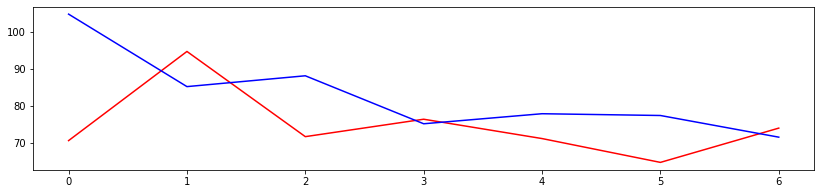

In [173]:
predict = predict[0]
test = test[0]

plt.figure(figsize=(14,3))
plt.plot(test, color='red');
plt.plot(predict, color = 'blue');